In [1]:
import sys 
import networkx as nx
import pandas as pd
import numpy as np
import pickle as pic
import random
import scipy.stats as stats

import cassiopeia.TreeSolver.simulation_tools.simulation_utils as sim_utils
import cassiopeia.TreeSolver.simulation_tools.dataset_generation as data_gen
from cassiopeia.TreeSolver.Node import Node
from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import subprocess

from Bio import Phylo as Phylo
from io import StringIO

#import seaborn as sns
import os

import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

# utils.install_packages('mnormt')
# utils.install_packages('TreeSimGM')
# utils.install_packages('ape')

<rpy2.rinterface_lib.sexp.NULLType object at 0x7fd182d13148> [RTYPES.NILSXP]

In [9]:
def maxDepth(network, node): #tree height
    if network.out_degree(node) == 0:
        return 1
    else:
        depths = []
        for i in network.successors(node):
            depths.append(maxDepth(network, i))
        return max(depths) + 1
    
def all_depths(network):
    root = [n for n in network if network.in_degree(n) == 0][0]
    depths = all_depths_helper(network, root)
    return depths, sum(depths)/len(depths)
    
def all_depths_helper(network, node):
    if (network.out_degree(node) == 0):
        return [1]
    else:
        depths = []
        for i in network.successors(node):
            depths.extend(all_depths_helper(network, i))
        return [x + 1 for x in depths]
    
def diameter(network): #tree diameter
    root = [n for n in network if network.in_degree(n) == 0][0]
    if (network.out_degree(root) == 0):  
        return 1
    ans = [-1]
    height_of_tree = maxDepth_help(network, root, ans)  
    return ans[0]

def maxDepth_help(network, node, ans): #tree_height helper for tree diameter
    if network.out_degree(node) == 0:
        ans[0] = max(ans[0], 1)
        return 1
    else:
        depths = []
        for i in network.successors(node):
            depths.append(maxDepth_help(network, i, ans))
        ans[0] = max(ans[0], 1 + sum(depths))  
        return max(depths) + 1

def degree_dist(network): #returns dist of out degrees, and average out degree
    out_degrees = []
    for i in network.nodes:
        out_degrees.append(network.out_degree(i))
    fullness = out_degrees.count(1)/len(out_degrees)
    return out_degrees, sum(out_degrees)/len(out_degrees), fullness

def degree_dist_leaves(network): #returns dist of leaf descendants of each node
    root = [n for n in network if network.in_degree(n) == 0][0]
    dist = []
    leaves_dist_helper(network, root, dist)
    return dist, sum(dist)/len(dist)
    
def leaves_dist_helper(network, node, dist):
    if network.out_degree(node) == 0:
        dist.append(0)
        return 1
    else:
        total_leaves = 0
        for i in network.successors(node):
            total_leaves += leaves_dist_helper(network, i, dist)
        dist.append(total_leaves)
        return(total_leaves)
    
def get_character_matrix(nodes, sampling_proportion = 1):
    
    char_arrays = []
    sel_size = round(sampling_proportion * len(nodes))
    sel_nodes = np.random.choice(nodes, sel_size, replace = False)
    for n in sel_nodes:
        chars = n.char_string.split("_")[0].split("|")
        char_arrays.append(chars)
        
    return pd.DataFrame(char_arrays)

# def states_per_char(network):
#     leaves = [n for n in network if network.out_degree(n) == 0]
#     cm = get_character_matrix(leaves)
#     unique_chars = [0 for n in range(0, cm.shape[1])]
#     seen = [[] for n in range(0, cm.shape[1])]
#     for j in range(0,cm.shape[1]):
#         for i in range(0,cm.shape[0]):
#             val = cm.iloc[i, j]
#             if val != '0' and val != '-' and val not in seen[j]:
#                 unique_chars[j] += 1
#                 seen[j].append(cm.iloc[i, j])
#     return unique_chars

def prune_directed_graph(network):
    root = [a for a in network.nodes()][0]
    if network.out_degree(root) > 0:
        for node in network.successors(root):
            directed_graph_helper(network, node, root)
    return
    
def directed_graph_helper(network, node, parent):
    network.remove_edge(node, parent)
    for i in network.successors(node):
            directed_graph_helper(network, i, node)
    return

def balance_dist(network):
    root = [n for n in network if network.in_degree(n) == 0][0]
    height_diffs = []
    max_ = [0]
    balance_dist_helper(network, root, height_diffs, max_)
    return height_diffs, sum(height_diffs)/len(height_diffs), max_[0]

def balance_dist_helper(network, node, ans, max_): #tree height helper for distribution of height differences
    if network.out_degree(node) == 0:
        return 1
    else:
        depths = []
        for i in network.successors(node):
            depths.append(balance_dist_helper(network, i, ans, max_))
        if len(depths) > 1:
            ans.append(max(depths) - min(depths))
            max_[0] = max(max_[0], max(depths) - min(depths))
        return max(depths) + 1
    
def get_colless(network):
    root = [n for n in network if network.in_degree(n) == 0][0]
    colless = [0]
    colless_helper(network, root, colless)
    n = len([n for n in network if network.out_degree(n) == 0 and network.in_degree(n) == 1]) 
    return colless[0], (colless[0] - n * np.log(n) - n * (np.euler_gamma - 1 - np.log(2)))/n
    
def colless_helper(network, node, colless):
    if network.out_degree(node) == 0:
        return 1
    else:
        leaves = []
        for i in network.successors(node):
            leaves.append(colless_helper(network, i, colless))
        colless[0] += abs(leaves[0] - leaves[1])
        return sum(leaves)
        
# def states_per_char(cm):
#     unique_chars = [0 for n in range(0, cm.shape[1])]
#     seen = [[] for n in range(0, cm.shape[1])]
#     for j in range(0, cm.shape[1]):
#         for i in range(0,cm.shape[0]):
#             val = cm.iloc[i, j]
#             if val != '0' and val != '-' and val not in seen[j]:
#                 unique_chars[j] += 1
#                 seen[j].append(val)
#     return unique_chars   

def states_per_char(cm):
    unique_chars = [0] * cm.shape[1]
#     unique_chars = list(cm.nunique())
#     unique_chars = [x-2 for x in ret]
    for j in range(0, cm.shape[1]):
        unique = set(cm.iloc[:, j])
        if '0' in unique:
            unique.remove('0')
        if '-' in unique:
            unique.remove('-')
        unique_chars[j] = len(unique)
    return unique_chars

def longest_path(node, ans):
    if network.out_degree(node) == 0:
        return
    for i in network.successors(node):
        ans[0] += network.edges()[node, i]['weight']
        longest_path(i, ans)
        break
        
def frange(start, stop, step):
    res, n = start, 1

    while res < stop:
        yield res
        res = start + n * step
        n += 1

def get_net_div(time, n, epsilon):
    ret = []
    test = robjects.r('''
    require(geiger)
    epsilon = ''' + str(epsilon) + '''
    r = bd.ms(time = ''' + str(time) + ''', n = ''' + str(n) + ''', epsilon = epsilon, crown = TRUE)
    lambda = r/(1-epsilon)
    lambda
    ''')
    for item in test.items():
        for i in item:
            if i != None:
                ret.append(i)

    test = robjects.r('''
    require(geiger)
    epsilon = ''' + str(epsilon) + '''
    r = bd.ms(time = ''' + str(time) + ''', n = ''' + str(n) + ''', epsilon = epsilon, crown = TRUE)
    lambda = r/(1-epsilon)
    mu = lambda * epsilon
    mu
    ''')
    for item in test.items():
        for i in item:
            if i != None:
                ret.append(i)
    return ret

def get_conf_int(time, div, epsilon, conf):
    ret = []
    test = robjects.r('''
    require(geiger)
    epsilon = ''' + str(epsilon) + '''
    ci = stem.limits(time = ''' + str(time) + ''', ''' + str(div) + ''', epsilon = epsilon, CI = ''' + str(conf) + ''')
    ci[1]
    ''')
    for item in test.items():
        for i in item:
            if i != None:
                ret.append(i)
    test = robjects.r('''
    require(geiger)
    epsilon = ''' + str(epsilon) + '''
    ci = stem.limits(time = ''' + str(time) + ''', ''' + str(div) + ''', epsilon = epsilon, CI = ''' + str(conf) + ''')
    ci[2]
    ''')
    for item in test.items():
        for i in item:
            if i != None:
                ret.append(i)
    
    return ret

In [11]:
def overlay_mutation_continuous(network, mutation_prob_map, basal_rate, cassette_size, epsilon):
    root = [n for n in network if network.in_degree(n) == 0][0]
    network.nodes[root]['parent_lifespan'] = 0
    
    for i in mutation_prob_map: #edit the mutation map to only include the probs 
                                #of mutating to each state, given that character is chosen to mutate
        sum = 0
        mutation_prob_map[i].pop('0', None)
        for j in mutation_prob_map[i]:
            sum += mutation_prob_map[i][j]
        new_probs = {}
        for j in mutation_prob_map[i]:
            new_probs[j] = mutation_prob_map[i][j]/sum
        mutation_prob_map[i] = new_probs
    
    mutation_helper_continuous(network, root, basal_rate, mutation_prob_map, root.char_vec, [], cassette_size, epsilon)
            
def mutation_helper_continuous(network, node, basal_rate, mutation_prob_map, curr_mutations, dropout_indices, cassette_size, epsilon):
    new_sample = curr_mutations.copy()
    new_dropout_indices = dropout_indices.copy()
    t = network.nodes[node]['parent_lifespan']
    
    p = 1 - (np.exp(-t * basal_rate))
    
#     print("new_sample")
#     print(new_sample)
    
#     print("new_dropout_indices")
#     print(new_dropout_indices)
    
    base_chars = []
    for i in range(0, len(new_sample)):
        if new_sample[i] == '0' and i not in new_dropout_indices:
            base_chars.append(i)
            
#     print("base_chars")
#     print(base_chars)
    draws = np.random.binomial(len(base_chars), p)
#     print(draws)
    chosen_ind = np.random.choice(base_chars, draws, replace=False)
#     print("chosen_ind")
#     print(chosen_ind)
    
#     print(chosen_ind)
    cassettes = {}
    for i in chosen_ind:
        values, probabilities = zip(*mutation_prob_map[i].items())
        new_character = np.random.choice(values, p=probabilities)
        new_sample[i] = new_character
        time = np.random.uniform(0.0, t)
        left = max(0, time - epsilon)
        right = min(t, time + epsilon)
        cass_num = i//cassette_size
        if cass_num in cassettes:
            cassettes[cass_num].append((left, right, i))
        else:
            cassettes[cass_num] = [(left, right, i)]
#     print(t)
#     print(cassettes)
            
    for cass_num in cassettes.keys():
        if len(cassettes[cass_num]) > 1:
            time_ranges = []
            for cut in cassettes[cass_num]:
                time_ranges.append(cut)
            time_ranges.sort(key = lambda x: x[0])
            
            seen = set()
#             print(time_ranges)
            for cut in time_ranges:
#                 print(cut)
#                 print(seen)
                if cut[2] in seen:
#                     print('continuing')
                    continue
                for cut2 in time_ranges:
#                     print(cut2)
#                     print(seen)
                    if cut2[2] in seen:
#                         print('continuing')
                        continue
                    if (cut[1] >= cut2[0]):
                        if cut[2] != cut2[2]:
#                             print('hit')
#                             print(cut, cut2)
                            for e in range(min(cut[2], cut2[2]), max(cut[2], cut2[2]) + 1):
                                if e not in new_dropout_indices:
                                    new_dropout_indices.append(e)
                                    seen.add(e)
                                    seen.add(e)
                            break
                seen.add(cut[2])      
    
#     print(new_dropout_indices)
        
#     for i in range(0, len(new_sample)//cassette_size):
#         if random.uniform(0, 1) <= 0.027:
#             for j in range(i * cassette_size, (i + 1) * cassette_size):
#                 new_dropout_indices.append(j)
    
    node.char_vec = new_sample
    node.char_string = '|'.join([str(char) for char in new_sample])
    network.nodes[node]['dropout'] = new_dropout_indices
    
    if network.out_degree(node) > 0:
        for i in network.successors(node):
            network.nodes[i]['parent_lifespan'] = network.get_edge_data(node, i)['weight']
            mutation_helper_continuous(network, i, basal_rate, mutation_prob_map, new_sample, new_dropout_indices, cassette_size, epsilon)

def overlay_heritable_dropout(network):
    root = [n for n in network if network.in_degree(n) == 0][0]
    h_dropout_helper(network, root)

def h_dropout_helper(network, node):
    new_sample = node.char_vec.copy()
    for i in network.nodes[node]['dropout']:
        new_sample[i] = '-'
    node.char_vec = new_sample
    node.char_string = '|'.join([str(char) for char in new_sample])

    if network.out_degree(node) > 0:
        for i in network.successors(node):
            h_dropout_helper(network, i)
            
def add_stochastic_leaves(leaves, dropout_prob, cassette_size):
    for node in leaves:
        sample = node.char_vec.copy()
        for i in range(0, len(sample)//cassette_size):
            if random.uniform(0, 1) <= dropout_prob:
                for j in range(i * cassette_size, (i + 1) * cassette_size):
                    if sample[j] != '*':
                        sample[j] = '-'
        node.char_vec = sample
        node.char_string = '|'.join([str(char) for char in sample])

In [12]:
def compute_priors(C, S, p, mean=0.01, disp=0.1, skew_factor = 0.05, num_skew=1, empirical = np.array([]), mixture = 0):
    
    sp = {}
    prior_probabilities = {}
    for i in range(0, C):
        if len(empirical) > 0:
            sampled_probabilities = sorted(empirical)
        else:
            sampled_probabilities = sorted([np.random.negative_binomial(mean,disp) for _ in range(1,S+1)])
        s = C % num_skew
        mut_rate = p * (1 + num_skew * skew_factor)
        prior_probabilities[i] = {'0': (1-mut_rate)}
        total = np.sum(sampled_probabilities)

        sampled_probabilities = list(map(lambda x: x / (1.0 * total), sampled_probabilities))
        
        if mixture > 0: 
            for s in range(len(sampled_probabilities)):
                if np.random.uniform() <= mixture:
                    sampled_probabilities[s] = np.random.uniform()
            
            sp[i] = sampled_probabilities 
            total = np.sum(sampled_probabilities)
            sampled_probabilities = list(map(lambda x: x / (1.0 * total), sampled_probabilities))
            
            
        for j in range(1, S+1):
            prior_probabilities[i][str(j)] = (mut_rate)*sampled_probabilities[j-1]

    return prior_probabilities, sp

def construct_topology(num_chars, div_rate, death_rate, fitness = None, num_leaves = None, time = None):
    
    if time == None:
        if fitness == None:
            test = robjects.r('''
                require(TreeSimGM)
                require(ape)
                test <- function ()
                {
                    yule <- sim.taxa(1, n=''' + str(num_leaves) + ''', 
                    waitsp="rexp(''' + str(div_rate) + ''')", 
                    waitext="rexp(''' + str(death_rate) + ''')", complete = FALSE)
                    write.tree(yule[[1]], file = "", append = FALSE, digits = 10, tree.names = FALSE)
                }
                test()
                ''')
        else:
            test = robjects.r('''
                require(TreeSimGM)
                require(ape)
                test <- function ()
                {
                    yule <- sim.taxa(1, n=''' + str(num_leaves) + ''', 
                    waitsp="rexp(''' + str(div_rate) + ''')", 
                    waitext="rexp(''' + str(death_rate) + ''')",
                    shiftsp=list(prob=''' + str(fitness_rate) + ''', strength=“runif(0.5,1.5)”),
                    complete = FALSE)
                    write.tree(yule[[1]], file = "", append = FALSE, digits = 10, tree.names = FALSE)
                }
                test()
                ''')
        
    elif num_leaves == None:
        try:
            if fitness == None:
                test = robjects.r('''
                    require(TreeSimGM)
                    require(ape)
                    test <- function ()
                    {
                        yule <- sim.age(1, age=''' + str(time) + ''', 
                        waitsp="rexp(''' + str(div_rate) + ''')", 
                        waitext="rexp(''' + str(death_rate) + ''')", complete = FALSE)
                        write.tree(yule[[1]], file = "", append = FALSE, digits = 10, tree.names = FALSE)
                    }
                    test()
                    ''')
            else:
                test = robjects.r('''
                    require(TreeSimGM)
                    require(ape)
                    test <- function ()
                    {
                        yule <- sim.age(1, age=''' + str(time) + ''', 
                        waitsp="rexp(''' + str(div_rate) + ''')", 
                        waitext="rexp(''' + str(death_rate) + ''')",
                        shiftsp=list(prob=''' + str(fitness_rate) + ''', strength=“runif(0.5,1.5)”),
                        complete = FALSE)
                        write.tree(yule[[1]], file = "", append = FALSE, digits = 10, tree.names = FALSE)
                    }
                    test()
                    ''')
        except Exception as e:
            if e.__class__.__name__ == 'RRuntimeError':          
                print("R Error: likely that lineage fully deceased by the end of experiment, no samples generated")
                return None, []
        
    else:
        print("Please specify either a time length of experiment or a number of cells desired")
        return
    
    for string in test.items():
        string
        
    tree = Phylo.read(StringIO(string[1]), 'newick')
    network = Phylo.to_networkx(tree)
    network = network.to_directed()
    prune_directed_graph(network)
    
    rdict = {}
    i = 0
    for n in network.nodes:
        nn = Node("StateNode" + str(i), [0] * num_chars, pid = i, is_target=False)
        i += 1
        rdict[n] = nn

    network = nx.relabel_nodes(network, rdict)
    
    leaves = [n for n in network if network.out_degree(n) == 0 and network.in_degree(n) == 1] 
    
    state_tree = Cassiopeia_Tree('simulated', network = network)
    return state_tree, leaves

In [4]:
path = "/data/yosef2/users/richardz/projects/discrete_birthdeath/Chow_trees"

size_c = []
max_heights_c = []
avg_heights_c = []
widths_c = []
avg_deg_c = []
avg_leaf_deg_c = []
balances_c = []
colless_c = []
colless_norm_c = []

for i in range(1, 106):
    tree = Phylo.read(path + "/ground_" + str(i) + ".nwk", 'newick')
    network = Phylo.to_networkx(tree)
    network = network.to_directed()
    prune_directed_graph(network)
    
    root = [a for a in network.nodes()][0]
    leaves = [n for n in network if network.out_degree(n) == 0]
    if len(leaves) == 0:
        continue
    size_c.append(len(leaves))
    max_heights_c.append(maxDepth(network, root))
    avg_heights_c.append(all_depths(network)[1])
    widths_c.append(diameter(network))
    avg_deg_c.append(degree_dist(network)[1])
    avg_leaf_deg_c.append(degree_dist_leaves(network)[1])
    balances_c.append(balance_dist(network)[1])
    val, norm_val = get_colless(network)
    colless_c.append(val)
    colless_norm_c.append(norm_val)

In [6]:
path = "/data/yosef2/users/richardz/projects/discrete_birthdeath/Chow_trees"

mls = []
total_times = []

for i in range(1, 106):
    tree = Phylo.read(path + "/ground_" + str(i) + ".nwk", 'newick')
    network = Phylo.to_networkx(tree)
    network = network.to_directed()
    prune_directed_graph(network)

    leaves = [n for n in network if network.out_degree(n) == 0]
    root = [n for n in network if network.in_degree(n) == 0][0]

    total_edge_weight = 0
    for i in network.edges(data = True):
        total_edge_weight += i[2]['weight']
    
    ans = [0]
    longest_path(root, ans)
    mls.append((len(leaves) - 2)/total_edge_weight)
    total_times.append(ans[0])
    
# print(root)
# for i in network.successors(root):
#     print(network.edges()[root, i])
#     for j in network.successors(i):
#         print(network.edges()[i, j])
# print(len(leaves))
# list(network.edges(data = True))

lambda_ts = [mls[i] * total_times[i] for i in range(0, len(mls))]

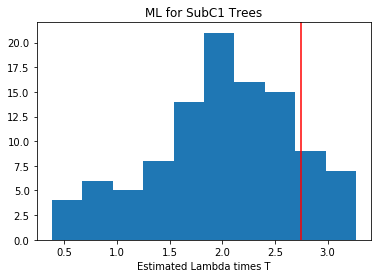

In [7]:
plt.hist(lambda_ts)
plt.title("ML for SubC1 Trees")
plt.xlabel("Estimated Lambda times T")
plt.axvline(x=2.75, c ='r', label = "Max hyperparam")
# plt.ylabel("KS p-value")
plt.show()

In [11]:
# for i in range(0,3):
#     num = np.random.randint(1, 106)
#     print(num, lambda_ts[num])

for i in range(0, len(size_c)):
    interval = get_conf_int(10, lambda_ts[i]/10, 0, 0.9)
    if size_c[i] < interval[0]:
        print("smaller: " + str(i))
    if size_c[i] > interval[1]:
        print("larger: " + str(i))

In [ ]:
%%capture
# tree_num = 4
# tree_num = 5
# tree_num = 18
tree_num = 42

division_rate = lambda_ts[tree_num]/10
size= []
max_heights = []
avg_heights = []
widths = []
avg_deg = []
avg_leaf_deg = []
colless_s = []
colless_norm_s = []
for i in range(0, 1000):
    tree, leaves = construct_topology(30, division_rate, 0, time = 10)
    while len(leaves) == 0:
        tree, leaves = construct_topology(30, division_rate, 0, time = 10)
    network = tree.network
    size.append(len(leaves))
#             root = [n for n in network if network.in_degree(n) == 0][0]
#             max_heights.append(maxDepth(network, root))
    avg_heights.append(all_depths(network)[1])
#             widths.append(diameter(network))

#     avg_deg.append(degree_dist(network)[1])
#     avg_leaf_deg.append(degree_dist_leaves(network)[1])
    val, norm_val = get_colless(network)
    colless_s.append(val)
    colless_norm_s.append(norm_val)

In [ ]:
plt.hist(size)
plt.title("Number of Samples for Tree " + str(tree_num + 1))
plt.xlabel("Size")
plt.axvline(x=size_c[tree_num], c ='r', label = "Max hyperparam")
# plt.ylabel("KS p-value")
plt.show()
lower = len([x for x in size if x < size_c[tree_num]])/1000
upper = len([x for x in size if x > size_c[tree_num]])/1000
print(lower + (1 - upper - lower) / 2)

plt.hist(avg_heights)
plt.title("Average Length of Path to each Leaf for Tree " + str(tree_num + 1))
plt.xlabel("Average Height")
plt.axvline(x=avg_heights_c[tree_num], c ='r', label = "Max hyperparam")
# plt.ylabel("KS p-value")
plt.show()
lower = len([x for x in avg_heights if x <= avg_heights_c[tree_num]])/1000
upper = len([x for x in avg_heights if x >= avg_heights_c[tree_num]])/1000
print(lower + (1 - upper - lower) / 2)

plt.hist(colless_s)
plt.title("Colless Index for Tree " + str(tree_num + 1))
plt.xlabel("Colless Index")
plt.axvline(x=colless_c[tree_num], c ='r', label = "Max hyperparam")
# plt.ylabel("KS p-value")
plt.show()
lower = len([x for x in colless_s if x < colless_c[tree_num]])/1000
upper = len([x for x in colless_s if x > colless_c[tree_num]])/1000
print(lower + (1 - upper - lower) / 2)


In [ ]:
%%capture
size_percentiles = []
colless_percentiles = []
avg_height_percentiles = []

for tree_num in range(0, len(lambda_ts)):

    division_rate = lambda_ts[tree_num]/10
    size= []
    max_heights = []
    avg_heights = []
    widths = []
    avg_deg = []
    avg_leaf_deg = []
    colless_s = []
    colless_norm_s = []
    for i in range(0, 1000):
        tree, leaves = construct_topology(30, division_rate, 0, time = 10)
        while len(leaves) == 0:
            tree, leaves = construct_topology(30, division_rate, 0, time = 10)
        network = tree.network
        size.append(len(leaves))
    #             root = [n for n in network if network.in_degree(n) == 0][0]
    #             max_heights.append(maxDepth(network, root))
        avg_heights.append(all_depths(network)[1])
    #             widths.append(diameter(network))

    #     avg_deg.append(degree_dist(network)[1])
    #     avg_leaf_deg.append(degree_dist_leaves(network)[1])
        val, norm_val = get_colless(network)
        colless_s.append(val)
        colless_norm_s.append(norm_val)
        
    lower = len([x for x in size if x < size_c[tree_num]])/1000
    upper = len([x for x in size if x > size_c[tree_num]])/1000
    size_percentiles.append(lower + (1 - upper - lower) / 2)
    
    lower = len([x for x in avg_heights if x <= avg_heights_c[tree_num]])/1000
    upper = len([x for x in avg_heights if x >= avg_heights_c[tree_num]])/1000
    avg_height_percentiles.append(lower + (1 - upper - lower) / 2)
    
    lower = len([x for x in colless_s if x < colless_c[tree_num]])/1000
    upper = len([x for x in colless_s if x > colless_c[tree_num]])/1000
    colless_percentiles.append(lower + (1 - upper - lower) / 2)

In [ ]:
plt.hist(size_percentiles)
plt.title("Size Percentiles")
plt.axvline(x=sum(size_percentiles)/len(size_percentiles), c ='r', label = "Max hyperparam")
# plt.ylabel("KS p-value")
plt.show()

plt.hist(avg_height_percentiles)
plt.title("Avg Height Percentiles")
plt.axvline(x=sum(avg_height_percentiles)/len(avg_height_percentiles), c ='r', label = "Max hyperparam")
# plt.ylabel("KS p-value")
plt.show()

plt.hist(colless_percentiles)
plt.title("Colless Percentiles")
plt.axvline(x=sum(colless_percentiles)/len(colless_percentiles), c ='r', label = "Max hyperparam")
# plt.ylabel("KS p-value")
plt.show()

In [ ]:
%%capture
division_rates = []
size_ps = []
colless_ps = []
colless_norm_ps = []
avg_heights_ps = []

for division_rate in frange(0.1, 0.401, 0.005):
    division_rates.append(division_rate)
    size_total = 0
    colless_total = 0
    colless_norm_total = 0
    avg_heights_total = 0
    for i in range(0, 10):
        size= []
        max_heights = []
        avg_heights = []
        widths = []
        avg_deg = []
        avg_leaf_deg = []
        colless_s = []
        colless_norm_s = []
        for i in range(1, 106):
            tree, leaves = construct_topology(30, division_rate, 0, time = 10)
            while len(leaves) == 0:
                tree, leaves = construct_topology(30, division_rate, 0, time = 10)
            network = tree.network
            size.append(len(leaves))
#             root = [n for n in network if network.in_degree(n) == 0][0]
        #             max_heights.append(maxDepth(network, root))
            avg_heights.append(all_depths(network)[1])
        #             widths.append(diameter(network))

        #     avg_deg.append(degree_dist(network)[1])
        #     avg_leaf_deg.append(degree_dist_leaves(network)[1])
            val, norm_val = get_colless(network)
            colless_s.append(val)
            colless_norm_s.append(norm_val)
        colless_total += stats.ks_2samp(colless_s, colless_c)[1]
        colless_norm_total += stats.ks_2samp(colless_norm_s, colless_norm_c)[1]
        size_total += stats.ks_2samp(size, size_c)[1]
        avg_heights_total += stats.ks_2samp(avg_heights, avg_heights_c)[1]
        
    size_ps.append(size_total/10)
    colless_ps.append(colless_total/10)
    colless_norm_ps.append(colless_norm_total/10)
    avg_heights_ps.append(avg_heights_total/10)

In [ ]:
div_lambda_t = [10 * x for x in division_rates]
plt.plot(div_lambda_t, colless_ps, 'b')
plt.title("Colless Index P-value Averaged over 10 Runs")
plt.xlabel("lambda times T")
plt.ylabel("KS p-value")
plt.show()

In [6]:
path = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/"

drop_perc_i = []
mut_perc_i = []
max_spc_i = []
avg_spc_i = []
size_i = []
num_chars_i = []

for i in range(1, 101):
    cm = pd.read_csv(path + 'lg' + str(i) + '/lg' + str(i) + '_character_matrix.txt', sep = '\t', index_col = 0)
    num_dropped = 0
    num_mut = 0
    num_dropped = (cm.values == '-').sum()
    num_mut = cm.shape[0] * cm.shape[1] - num_dropped - (cm.values == '0').sum()
    drop_perc_i.append(num_dropped/(cm.shape[0] * cm.shape[1]))
    mut_perc_i.append(num_mut/(cm.shape[0] * cm.shape[1] - num_dropped))
    
    spc = states_per_char(cm)
    avg_spc_i.append(sum(spc)/len(spc))
    max_spc_i.append(max(spc))
    
    size_i.append(cm.shape[0])
    num_chars_i.append(cm.shape[1])

In [ ]:
path = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/"
cm = pd.read_csv(path + 'lg' + str(31) + '/lg' + str(31) + '_character_matrix.txt', sep = '\t', index_col = 0)

seen_i = set()
for k in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm.iloc[k,j] not in seen_i:
            seen_i.add(cm.iloc[k,j])
print(cm.shape)
print(len(seen_i) - 2)
print(states_per_char(cm))

num_dropped = (cm.values == '-').sum()
num_mut = cm.shape[0] * cm.shape[1] - num_dropped - (cm.values == '0').sum()

print(num_mut/(cm.shape[0] * cm.shape[1] - num_dropped))
cm.nunique()
# print(num_dropped)
# print(num_mut)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(cm)
# (cm.values != '-').sum()
# cm.shape[0] * cm.shape[1] - num_mut - num_dropped - (cm.values == '0').sum()

In [7]:
indel_probs = pd.read_csv('/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/ALL.5k.indel_priors.txt', sep = '\t', index_col = 0)

In [ ]:
test = stats.gaussian_kde(indel_probs['count'])
x = np.arange(0, 800, 50)
y = test(x)
plt.plot(x, y)
y

In [ ]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit([indel_probs['freq']])
kde

In [86]:
tree_num = 68
print(size_i[tree_num], num_chars_i[tree_num], drop_perc_i[tree_num], mut_perc_i[tree_num], max_spc_i[tree_num], avg_spc_i[tree_num])

52 30 0.175 0.22999222999222999 5 2.7333333333333334


In [85]:
sum(mut_perc_i)/len(mut_perc_i)

0.5390760705866637

In [ ]:
# new = np.random.choice(indel_probs['freq'], size = 50)
# sum_freq = sum(new)
# new = [x/sum_freq for x in new]
# dist = {}
# sort_dist = sorted(new, reverse = True)
# for i in range(1, len(new) + 1):
#     dist[str(i)] = sort_dist[i - 1]
# prior_probabilities = {}
# for i in range(0, num_chars_i[tree_num]):
#     prior_probabilities[i] = dist
# dist

In [8]:
sum_freq = sum(indel_probs['freq'])
indel_probs['dist'] = [x/sum_freq for x in indel_probs['freq']]
len(indel_probs['dist'])
dist = {}
sort_dist = sorted(indel_probs['dist'], reverse = True)
for i in range(1, len(indel_probs['dist']) + 1):
    dist[str(i)] = sort_dist[i - 1]
len(dist)

9662

In [ ]:
print(max_spc_i[30])
mutation_prob_map = pd.read_pickle('/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/lg31/lg31_priors.pkl')
# lens = []
# for i in range(0, 57):
#     lens.append(len(mutation_prob_map[i]))
# print(max(lens))
# mutation_prob_map = {}
# dist = {}
# for i in range(1, 200):
#     dist[str(i)] = 0.005
# for i in range(0, num_chars_i[tree_num]):
#     mutation_prob_map[i] = dist
mutation_prob_map

vals = []
for i in mutation_prob_map:
    for j in mutation_prob_map[i]:
        vals.append(mutation_prob_map[i][j])
boot = np.random.choice(vals, replace = True, size = 1000)

dist = {}
for i in range(1, len(boot) + 1):
    dist[str(i)] = boot[i - 1]
dist





In [89]:
# max_percentiles = []
# avg_percentiles = []
# mut_percentiles = []

sampling_rate = 0.8
samp_scale = 1/sampling_rate

prior_probabilities = {}
for i in range(0, num_chars_i[tree_num]):
    prior_probabilities[i] = dist

# for tree_num in range(30, 100):
# for ratio in frange(0.0, 1.01, 0.05):
    
print(tree_num + 1)

mut_rate = np.log(1 - mut_perc_i[tree_num])/(-100)
print(round(size_i[tree_num] * samp_scale))
print(mut_rate)
drop_perc = []
mut_perc = []
max_spc = []
avg_spc = []

vals = get_net_div(100, round(size_i[tree_num] * samp_scale), 0.15)
print(vals)

for i in range(0, 100):

    tree, leaves = construct_topology(num_chars_i[tree_num], vals[0], vals[1], num_leaves = round(size_i[tree_num] * samp_scale))
    network = tree.network
    overlay_mutation_continuous(network, prior_probabilities, mut_rate, 3, 1)
    overlay_heritable_dropout(network)
    add_stochastic_leaves(leaves, 0.17, 3)

    cm = get_character_matrix(leaves, sampling_rate)
    print(cm.shape)
#     print(cm.shape)
    #     seen = set()
    #     for k in range(cm.shape[0]):
    #         for j in range(cm.shape[1]):
    #             if cm.iloc[k,j] not in seen:
    #                 seen.add(cm.iloc[k,j])

    #     print(len(seen) - 2)
    #     print(cm.nunique())
    #     with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #         print(cm)

    #     break
    num_dropped = (cm.values == '-').sum()
    num_mut = cm.shape[0] * cm.shape[1] - num_dropped - (cm.values == '0').sum()
    #     for k in range(cm.shape[0]):
    #         for j in range(cm.shape[1]):
    #             if cm.iloc[k,j] == "-" or cm.iloc[k,j] == "*":
    #                 num_dropped += 1
    #             if cm.iloc[k,j] != "-" and cm.iloc[k,j] != "*" and cm.iloc[k,j] != "0":
    #                 num_mut += 1
    drop_perc.append(num_dropped/(cm.shape[0] * cm.shape[1]))
    mut_perc.append(num_mut/((cm.shape[0] * cm.shape[1]) - num_dropped))

    spc = states_per_char(cm)
    avg_spc.append(sum(spc)/len(spc))
    max_spc.append(max(spc))

#     lower = len([x for x in max_spc if x < max_spc_i[tree_num]])/100
#     upper = len([x for x in max_spc if x > max_spc_i[tree_num]])/100
#     max_percentiles.append(lower + (1 - upper - lower) / 2)

#     lower = len([x for x in avg_spc if x < avg_spc_i[tree_num]])/100
#     upper = len([x for x in avg_spc if x > avg_spc_i[tree_num]])/100
#     avg_percentiles.append(lower + (1 - upper - lower) / 2)

#     lower = len([x for x in mut_perc if x < mut_perc_i[tree_num]])/100
#     upper = len([x for x in mut_perc if x > mut_perc_i[tree_num]])/100
#     mut_percentiles.append(lower + (1 - upper - lower) / 2)

69
65
0.002613546732661387
[0.040702374369370464, 0.00610535615540557]
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)
(52, 30)


In [ ]:
print(max_percentiles)
print(avg_percentiles)
print(mut_percentiles)
[0.9299999999999999, 0.9450000000000001, 0.95, 0.965, 0.985, 1.0, 0.985, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.96, 0.97, 0.97, 0.995, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.5, 0.54, 0.5700000000000001, 0.54, 0.53, 0.7, 0.62, 0.69, 0.5900000000000001, 0.61, 0.62, 0.6699999999999999, 0.72, 0.6599999999999999, 0.78, 0.6799999999999999, 0.73]

In [26]:
# exp = size_i[tree_num] * (1 - np.exp(-100 * mut_rate))
# vals = [1 - (1 - q)**exp for q in dist.values()]
# sum(vals)

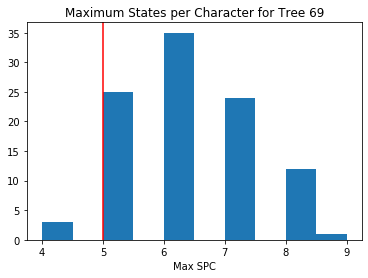

0.155


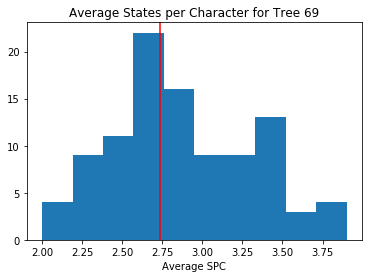

0.43


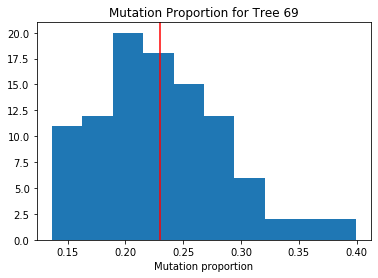

0.55


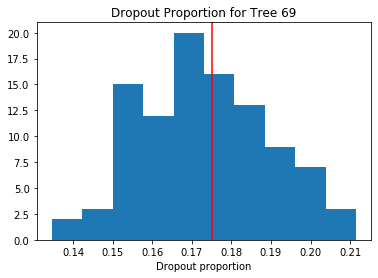

0.62


In [90]:
plt.hist(max_spc)
plt.title("Maximum States per Character for Tree " + str(tree_num + 1))
plt.xlabel("Max SPC")
plt.axvline(x=max_spc_i[tree_num], c ='r', label = "Max hyperparam")
# plt.ylabel("KS p-value")
plt.show()
lower = len([x for x in max_spc if x < max_spc_i[tree_num]])/100
upper = len([x for x in max_spc if x > max_spc_i[tree_num]])/100
print(lower + (1 - upper - lower) / 2)


plt.hist(avg_spc)
plt.title("Average States per Character for Tree " + str(tree_num + 1))
plt.xlabel("Average SPC")
plt.axvline(x=avg_spc_i[tree_num], c ='r', label = "Max hyperparam")
# plt.ylabel("KS p-value")
plt.show()
lower = len([x for x in avg_spc if x < avg_spc_i[tree_num]])/100
upper = len([x for x in avg_spc if x > avg_spc_i[tree_num]])/100
print(lower + (1 - upper - lower) / 2)

plt.hist(mut_perc)
plt.title("Mutation Proportion for Tree " + str(tree_num + 1))
plt.xlabel("Mutation proportion")
plt.axvline(x=mut_perc_i[tree_num], c ='r', label = "Max hyperparam")
# plt.ylabel("KS p-value")
plt.show()
lower = len([x for x in mut_perc if x < mut_perc_i[tree_num]])/100
upper = len([x for x in mut_perc if x > mut_perc_i[tree_num]])/100
print(lower + (1 - upper - lower) / 2)

plt.hist(drop_perc)
plt.title("Dropout Proportion for Tree " + str(tree_num + 1))
plt.xlabel("Dropout proportion")
plt.axvline(x=drop_perc_i[tree_num], c ='r', label = "Max hyperparam")
# plt.ylabel("KS p-value")
plt.show()
lower = len([x for x in drop_perc if x < drop_perc_i[tree_num]])/100
upper = len([x for x in drop_perc if x > drop_perc_i[tree_num]])/100
print(lower + (1 - upper - lower) / 2)

In [ ]:
div_lambda_t = [10 * x for x in division_rates]
plt.plot(div_lambda_t, colless_ps, 'b')
plt.title("Colless Index P-value Averaged over 10 Runs")
plt.xlabel("lambda times T")
plt.ylabel("KS p-value")
plt.show()

In [ ]:
num_chars = 57
sum_freq = sum(indel_probs['freq'])
indel_probs['dist'] = [x/sum_freq for x in indel_probs['freq']]
len(indel_probs['dist'])
dist = {}
sort_dist = sorted(indel_probs['dist'], reverse = True)
for i in range(0, len(indel_probs['dist'])):
    dist[str(i)] = sort_dist[i]
prior_probabilities = {}
for i in range(0, num_chars):
    prior_probabilities[i] = dist

In [ ]:
mutation_rate = 0.2
prior_probabilities = compute_priors(30, 100, mutation_rate, 5, 0.5, skew_factor=0.0, num_skew=1)[0]
#overlay_mutation_continuous(tree.network, prior_probabilities, mutation_rate, 10, 1.5)

In [ ]:
import statistics
print(statistics.mean(sorted(size_i)[:-3]))
print(statistics.variance(sorted(size_i)[:-3]))

In [ ]:
division_rates = []
death_rates = []
size_ps = []

division_rate = 0.0687
death_rate = 0.01749

for division_rate in frange(0.05, 0.0801, 0.001):
    for death_rate in frange(0, 0.03, 0.005):
        division_rates.append(division_rate)
        death_rates.append(death_rate)
        print(division_rate, death_rate)
        size_total = 0
        for i in range(0, 5):
            print("new run: " + str(i))
            size= []
            for i in range(1, 101):
                tree, leaves = construct_topology(30, division_rate, death_rate, time = 100)
                while len(leaves) == 0:
                    tree, leaves = construct_topology(30, division_rate, death_rate, time = 100)
                network = tree.network
                size.append(len(leaves))
            size_total += stats.ks_2samp(size, size_i)[1]

        size_ps.append(size_total/10)

In [ ]:
data = [division_rates, death_rates, size_ps]
df = pd.DataFrame(data)
df = df.T
df = df.rename(columns = {0: 'Division', 1: 'Death', 2: 'Size_p'})
df.to_csv('hyperparam_testing.txt', sep = '\t')

In [ ]:
params = pd.read_csv('hyperparam_testing.txt', sep = '\t', index_col = 0)

In [ ]:
size_ps_np = np.array(params['Size_p'])
params['Division'] = [round(x, 3) for x in params['Division']]
size_ps_np = size_ps_np.reshape(21, 6)

fig, ax = plt.subplots()
im = ax.imshow(size_ps_np)

ax.set_yticks(np.arange(len(set(params['Division']))))
ax.set_xticks(np.arange(len(set(params['Death']))))
ax.set_yticklabels(sorted(list((set(params['Division'])))))
ax.set_xticklabels(sorted(list((set(params['Death'])))))

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

ax.set_title("P-values on Comparisons to Metasasis Data Sample Size (averaged over 5 runs)")

plt.colorbar(im)
plt.show()